# <center>"They are good dogs Brent"</center>
## <center>A quick analysis of the WeRateDogs Twitter archive</center>
### by Lucas Basilio Aledi

<a id='table'></a>
## Table of Contents

* 1\. <a href="#intro">Introduction - "Why are you so mad Bront"</a>
* 2\. <a href="#explain">Explanatory Data Analysis</a>
    * 2.1\.) <a href="#question1">What tweets got most and least engagement from the audience?</a>
        - 2.1.1\. Is there a difference in engagement for tweets with and without a dog image?
        - 2.1.2\. What dog breed created most and least engagement?
    * 2.2\.) <a href="#question2">Do dog breeds, on average, get rated differently?</a> 
    * 2.3\.) <a href="#question3">Is there a correlation between rate and engagement?</a>
* 3\. <a href="#conclusions">Conclusions - "They are good dogs Brent"</a>

<a id='intro'></a>
## 1. Introduction - "Why are you so mad Bront"
Ok, fellas. This time, we have been asked to wrangle and investigate WeRateDogs' Twitter data. After some wrangling, the dataframe analyzed contains information on +2300 tweets, ranging from the id of a particular tweet, to its date of creation, text and length, as well as the number of times it has been liked or retweeted. It contains basic tweet data as they stood on August 1, 2017, including [this memorable exchange](https://knowyourmeme.com/memes/theyre-good-dogs-brent).

With it, let's  ponder over and seek possible answers for the following questions:
            
* 1\) <a href="#question1">Is there a difference in engagement for tweets with and without a dog image?</a>

* 2\) <a href="#question2">Do dog breeds, on average, get rated differently?</a> 

* 3\) <a href="#question3">Is there a correlation between rate and engagement?</a>

Ok! Enough talking. Let's dive right in!

In [4]:
import os
import requests
import json
import tweepy
from PIL import Image
from IPython import display
from io import BytesIO
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# connect to database
engine = create_engine('sqlite:///tweet_archive.db')
# load dataframe
df = pd.read_sql('SELECT * FROM master', engine)

[back to top](#table)
<a id='question1'></a>
### 1) Is there a difference in engagement for tweets with and without a dog image?
Ok. As we are dealing with one of the most important social media platforms out there, why not start by checking which tweets were most and least engaging? For that, Twitter has the [Engagement API](https://developer.twitter.com/en/docs/twitter-api/enterprise/engagement-api/overview) which provides, for instance, total metric for impressions, engagements, favorites, replies, retweets, quote tweets, and video views. That's, however, not for free.

Well, we need to create, then, our own engagement metric and, for that, we'll use the number of times users liked or retweeted a specific tweet. The criteria we'll be using is pretty simple: the larger the number of likes and retweeted, the more engaging the content. The criteria could be described as $Engagement= favorites + RTs$.

Let's first take a quick look at the distribution of engagement.

In [5]:
# creating new engagement column
df["engagement"]= df["favorites"] + df["retweets"]

In [10]:
# list of RT tweet_ids 
rt_ids= list(df[df.text.str.startswith("RT") == True]['tweet_id'])
# make df to be a dataframe not containing those tweet_ids
df= df[~df['tweet_id'].isin(rt_ids)]

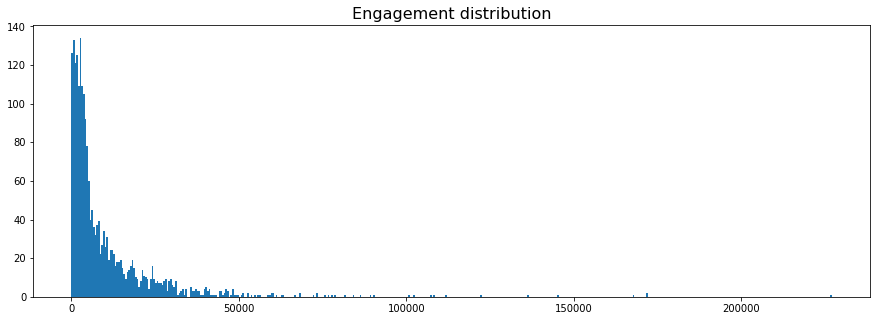

In [38]:
# engagement distribution
plt.figure(figsize=[15,5])
binsize= 500
bins_e= np.arange(df.engagement.min(),df.engagement.max()+binsize, binsize)
plt.hist(data= df, x= "engagement", bins= bins_e)
plt.title("Engagement distribution", fontsize=16)
plt.show()

This could be the case for a scale transformation. The distribution is heavily skewed to the right following an aproximate log-normal distribution. Let's try a logarithmic transformation to the data and see if it then follows a normal distribution.

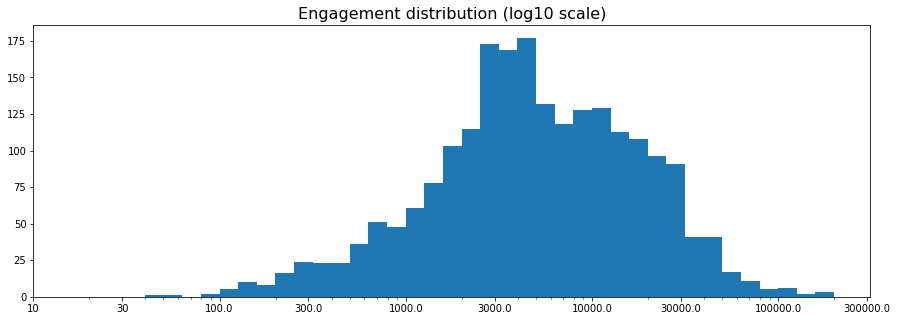

In [37]:
# engagement distribution
plt.figure(figsize=[15,5])
ticks= [10, 30, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
labels= ["{}".format(v) for v in ticks]
bins_e= 10 ** np.arange(1.4, 5.4, .1)
plt.hist(data= df, x= "engagement", bins= bins_e)
plt.xscale("log")
plt.xticks(ticks, labels)
plt.title("Engagement distribution (log10 scale)", fontsize=16)
plt.show()

As expected, once the logarithmic transformation is applied, the data looks more normally distributed, with the majority of tweets getting engaged from 3000 to 10000 times.

To finally answer this question, let's plot 2 histograms on the same axis comparing the distributions for tweets with and without a dog image.

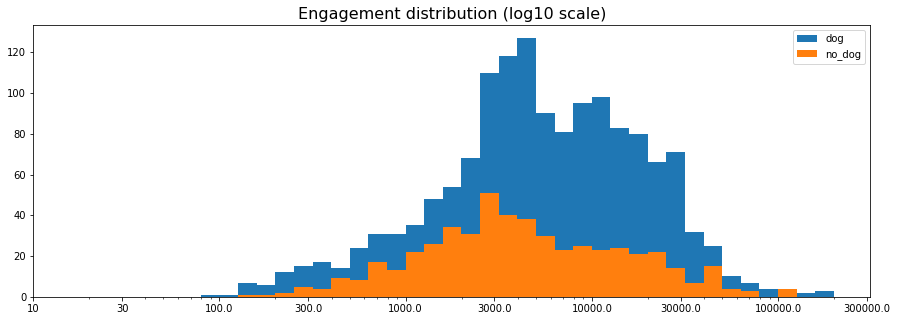

In [36]:
# separating df by p1_dog value
dog= df.query("p1_dog == 1")
no_dog= df.query("p1_dog == 0")

# ploting histograms
fig, ax = plt.subplots(figsize=[15,5])
for a in [dog, no_dog]:
    ticks= [10, 30, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
    labels= ["{}".format(v) for v in ticks]
    bins_e= 10 ** np.arange(1.4, 5.4, .1)
    plt.hist(data= a, x= "engagement", bins= bins_e)
    plt.xscale("log")
    plt.xticks(ticks, labels)
    plt.legend(["dog", "no_dog"])
plt.title("Engagement distribution (log10 scale)", fontsize=16)
plt.show()

As one would have expected, there seems to be a difference in engagement levels between tweets with and without the image of a dog. Tweets with it have, on average, more engagement than those without one. 

A really important disclaimer should be made here. In assessing whether the image on the tweet had or not a dog depicted, we came to realize that some entries in the data may not be as reliable as we'd have liked. Therefore, this insight should be taken with a grain of salt.

[back to top](#table)
<a id='question2'></a>
### 2. Do dog breeds, on average, get rated differently?
Given the large number of unique breeds in the dataset (111 in total!), what we're going to do is to set a threshhold from which we'll consider a dog breed for analysis. That's to say, we'll set a minimum of 50 occurrences of a specific dog breed.

In [17]:
# sets min 50 occurrences
engage_breeds= df.groupby('p1').filter(lambda x: len(x) > 50).sort_values('engagement')

And, by doing so, we're down to the top 5 out of the initial 111 dog breeds in the dataset. Great!

Let's now check the distribution of engagement for those and, if necessary, get rid of any potential outliers.

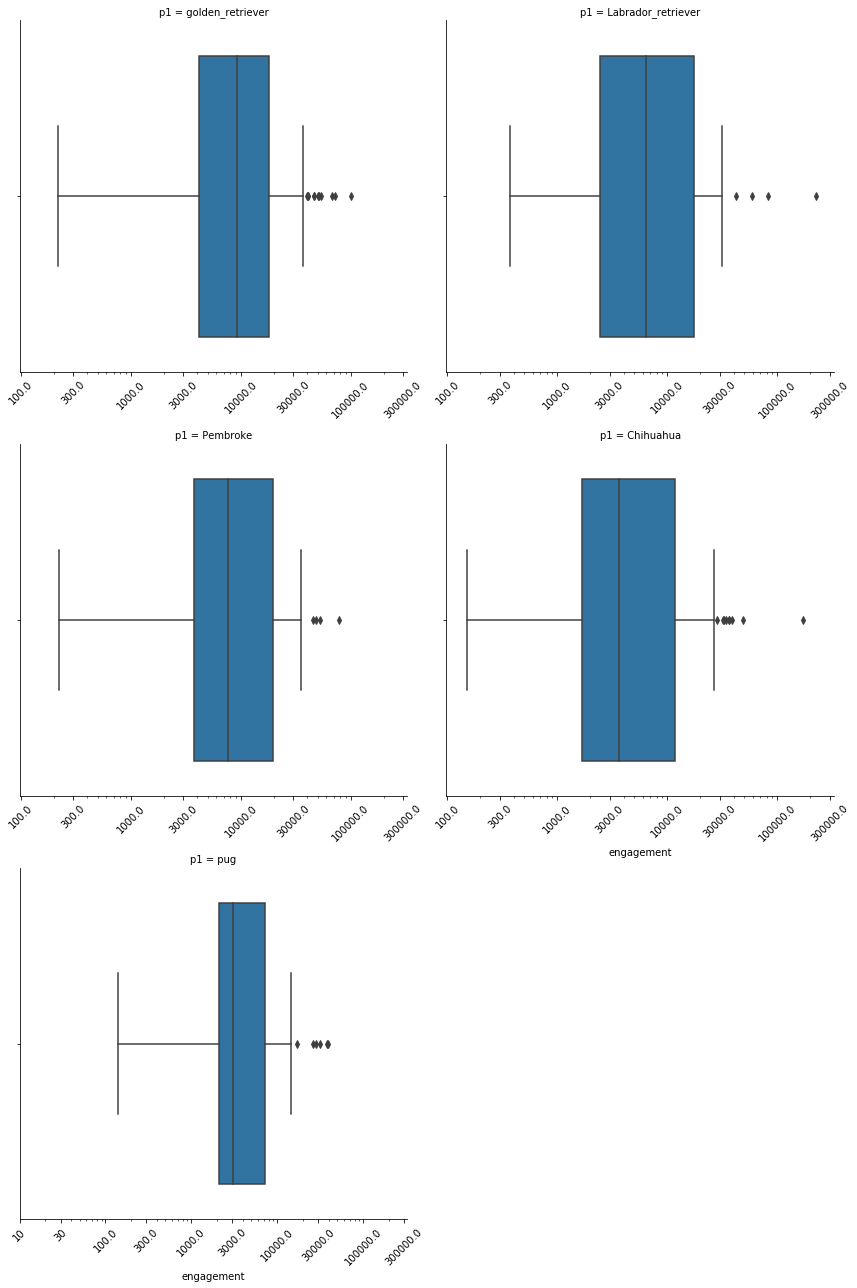

In [18]:
# check those engagement distributions
dog_breeds= engage_breeds.groupby('p1')['engagement'].describe().sort_values('mean', ascending= False).index.tolist()
ticks= [10, 30, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
labels= ["{}".format(v) for v in ticks]
g= sb.FacetGrid(data=engage_breeds, col='p1', col_wrap= 2, height=6, col_order= dog_breeds)
g.map(sb.boxplot, 'engagement', order= dog_breeds)
g.set(xscale = 'log')
plt.xticks(ticks, labels)

# adding xticks to all rows, if necessary
[ax.tick_params(labelbottom=True) for ax in g.axes.flatten()]

# rotating xticks on all rows
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat] 

# increase space between rows
g.fig.tight_layout()

plt.show()

All right! From the information provided by the graph above, it seems that different dog breeds generate different levels of engagement, with *golden retrievers* looking like the ones with better engagement. Important to notice, however, that there are some outliers within each dog breed. Let's now get rid of them and see whether they had any effect on average engagement level.

In [19]:
# reset_index so indices will match
clean_breeds= engage_breeds.copy()
clean_breeds= clean_breeds.reset_index(drop=True)
# picking outliers indices
dog_breeds= clean_breeds.p1.value_counts().index.tolist()
index_tracker= []
# loop through 'engagement' by dog breed ('p1)' and interquartile (IQR)
for breed in dog_breeds:
    Q1 = clean_breeds[clean_breeds['p1'].values== breed]['engagement'].quantile(0.25)
    Q3 = clean_breeds[clean_breeds['p1'].values== breed]['engagement'].quantile(0.75)
    IQR = Q3 - Q1
    for i in clean_breeds.index:
        if not(clean_breeds['engagement'].values[i] >= (Q1 - 1.5 * IQR)) & (clean_breeds['engagement'].values[i] <= (Q3 + 1.5 *IQR)) and i not in index_tracker:
            index_tracker.append(i)
        else:
            None
# droping outliers
clean_breeds = clean_breeds.drop(index_tracker, axis= 0)

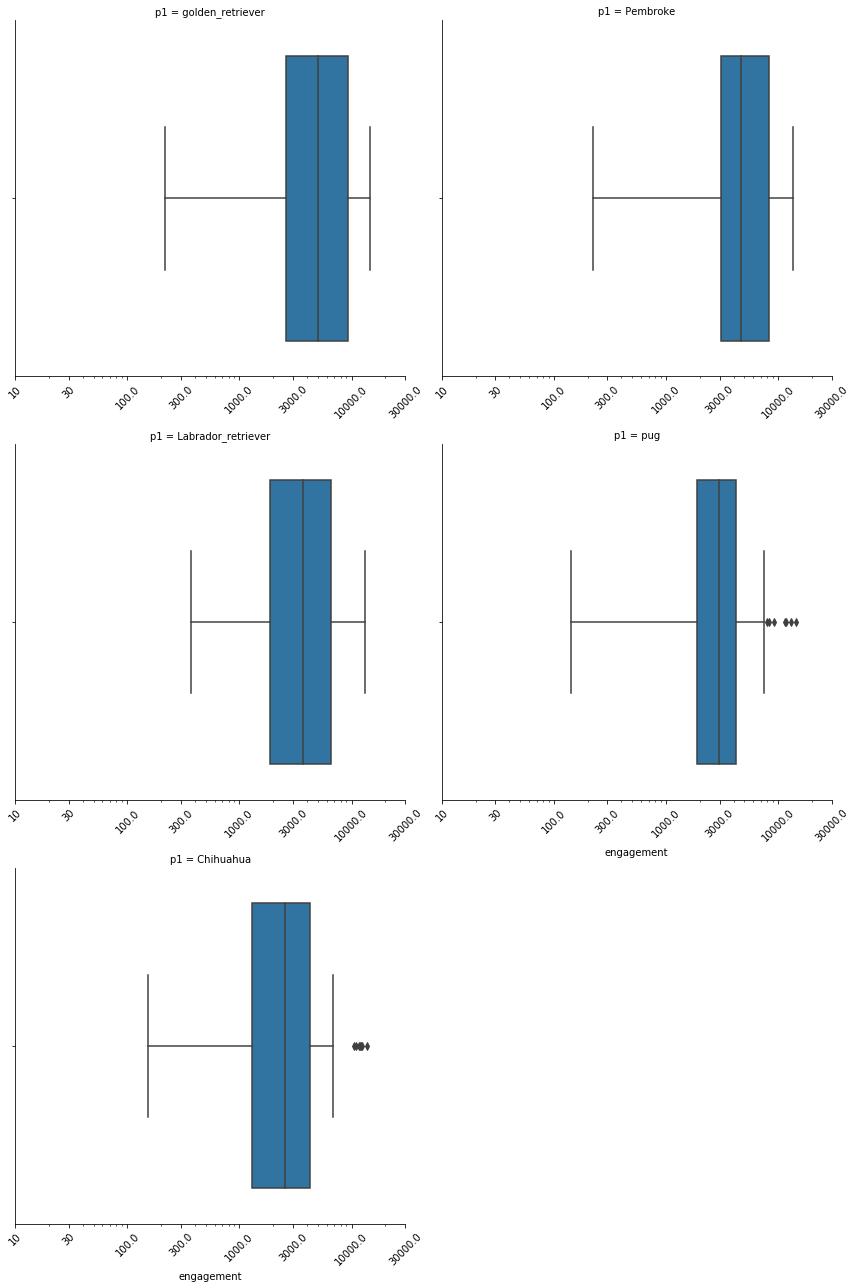

In [21]:
# re-check engagement without outliers
dog_breeds= clean_breeds.groupby('p1').engagement.describe().sort_values('mean', ascending= False).index.tolist()
ticks= [10, 30, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
labels= ["{}".format(v) for v in ticks]
g= sb.FacetGrid(data=clean_breeds, col='p1', col_wrap= 2, height=6, col_order= dog_breeds)
g.map(sb.boxplot, 'engagement', order= dog_breeds)
g.set(xscale = 'log')
plt.xticks(ticks, labels)
plt.xlim(10, 3e4)

# adding xticks to all rows, if necessary
[ax.tick_params(labelbottom=True) for ax in g.axes.flatten()]

# rotating xticks on all rows
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat] 

# increase space between rows
g.fig.tight_layout()

plt.show()

Ok! After cleaning for outliers, we can already see some changes. First of all, as expected, the average engagement for all breeds have suffered a considerable reduction: from about 7k-10k, down to 3k-6k. Secondly, *pembrokes* overtook *labrador retrievers*, but still falling behind only to *golden retrievers*. Also, *pugs* took the 4th place from *chihuahuas*.

That being said, a couple of remarks must be made at this point:
   * The number of occurrences for different breeds of dogs varies. In other words, had the number of observations been equal for all breeds, the results could have been different;
   * The change in the mean for all breeds shows the importance of taking outliers into consideration when analyzing the data;
   * Given tha large number of dog breeds, as mentioned before, it'd be interesting to see the results of categorizing them using machine learning.
   
Finally, let's tackle the final question:

[back to top](#table)
<a id='question3'></a>
### 3. Is there a correlation between rate and engagement?
For visualizing that, let's keep it simple and use a scatter plot.

In [22]:
# leaving outliers out
Q1= df.normalized_rating.quantile(0.25)
Q3= df.normalized_rating.quantile(0.75)
IQR= Q3 - Q1
query= "normalized_rating >= (@Q1 - 1.5*@IQR) and normalized_rating <= (@Q3 + 1.5*@IQR)"
df_clean= df.query(query)

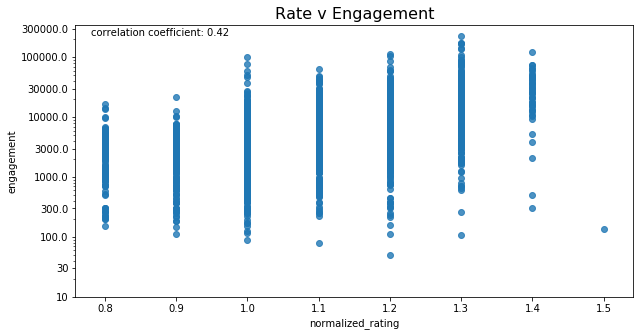

In [39]:
# rate v engagement
corr= df_clean.engagement.corr(df_clean.normalized_rating)
plt.figure(figsize=[10,5])
sb.regplot(data=df_clean, y='engagement', x='normalized_rating', fit_reg= False)
plt.yscale('log')
ticks= [10, 30, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
labels= ["{}".format(v) for v in ticks]
plt.yticks(ticks, labels)
plt.text(s='correlation coefficient: {:.2f}'.format(corr), y=df_clean.engagement.max()+100,
         x=.78);
plt.title("Rate v Engagement", fontsize=16)
plt.show()

Surprisingly, it seems that there's only a moderate correlation between engagement and rating. Other variables could be playing a bigger role than anticipated, for instance, dog breed and, as a consequence, the dog's physical characteristics. Also, the text of the tweet itself could be relevant on this matter. For example, we could ascertain whether the text being positive, negative or neutral would have any effect on the engagement levels. This could be done through [sentiment analysis](https://medium.com/dev-genius/training-an-ml-model-for-sentiment-analysis-in-python-63b6b8c68792), but that would be out of the scope of the current project.

[back to top](#table)

<a id='conclusions'></a>
# Conclusions - "They are good dogs Brent"

Nicely done! So, we could summarize our findings as follows:
   * 1\. It could be interesting to review the neural network used to identify the dogs on all tweets. It seems that it could be improved, given that many images were predicted inaccurately;
   * 2\. The engagement distribution is heavily skewed to the right following a log-normal distribution. The bulk of the distribution is within the 3k-10k range;
   * 3\. Tweets which depict a dog perform better in terms of engagement and, yes, different dog breeds perform differently, with *golden retrievers* being the most engaging dogs;
   * 4\. Finally, rates have a surprisingly moderate correlation with engagement. This could be indicative of the fact that there are some hidden variables out there influencing the level of engagement (e.g., dog breed, text sentiment, etc). As curiosity is a inherently human characteristic, we are very likely to dive into those hypothesis soon.